In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT LIBRARIES/DATASETS

In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [3]:
datafolder = "/content/drive/MyDrive/FY_BTech_Project/data"
os.chdir("/content/drive/MyDrive/FY_BTech_Project")

In [4]:
# Check the number of images in the dataset
data = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data', i))
  for j in train_class:
    img = os.path.join('data', i, j)
    data.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(data)))


Number of train images : 3662 



# PERFORM DATA EXPLORATION AND DATA VISUALIZATION

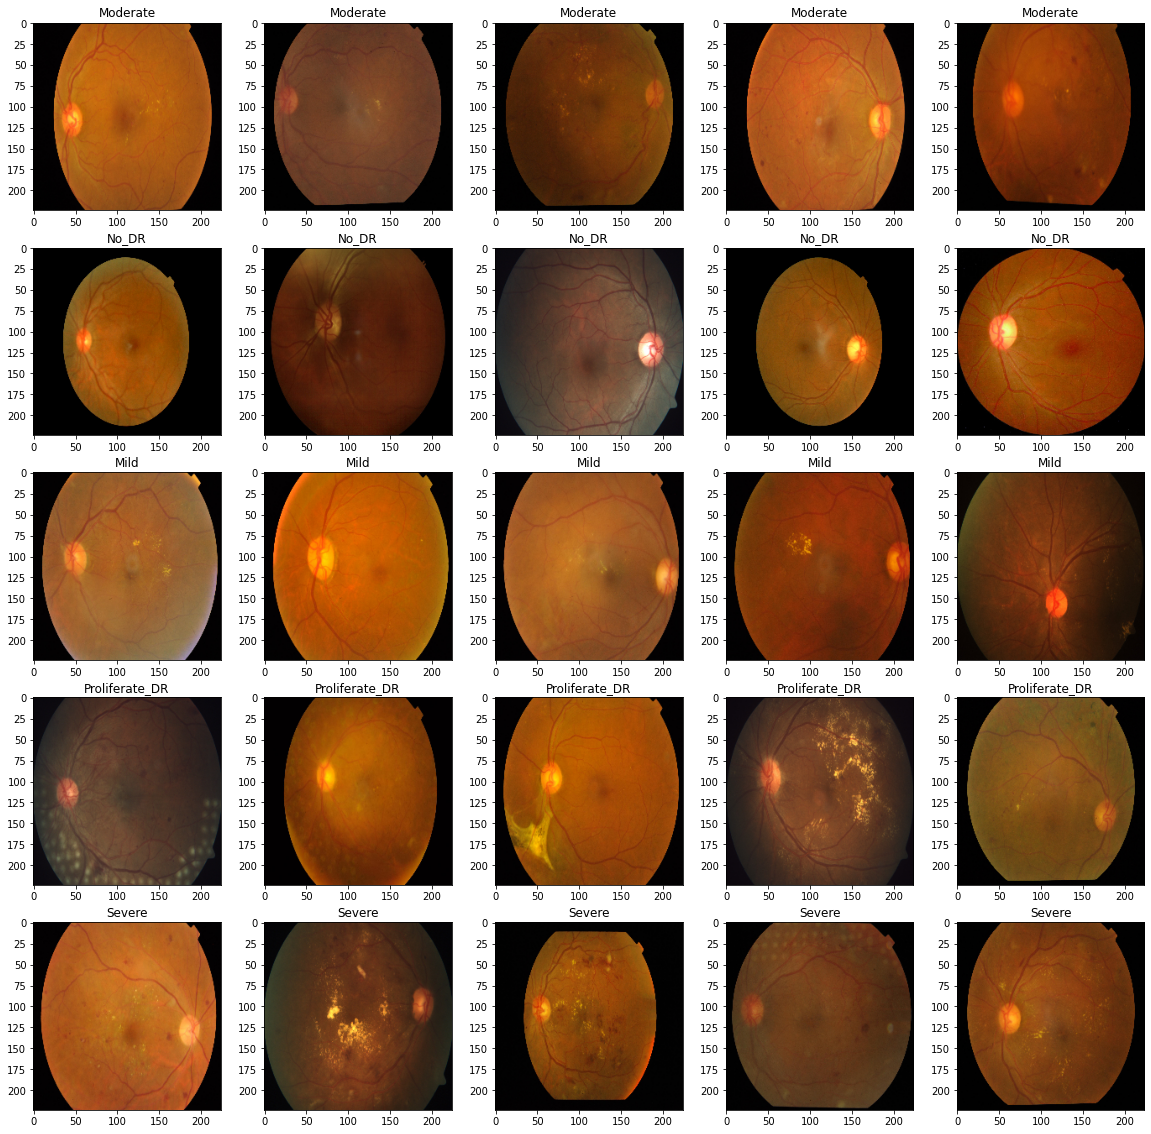

In [5]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir(datafolder):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('data', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('data', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1



In [6]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
total = 0;
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))
  total+=len(train_class)  
print("\n\tNumber of total images = {}".format(total))

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Mild = 370 

Number of images in Proliferate_DR = 295 

Number of images in Severe = 193 


	Number of total images = 3662


In [7]:
retina_df = pd.DataFrame({'Image': data,'Labels': label})
retina_df

Image    Labels
0     data/Moderate/0afdfe5f422c.png  Moderate
1     data/Moderate/064af6592ba6.png  Moderate
2     data/Moderate/0a1076183736.png  Moderate
3     data/Moderate/0af296d2f04a.png  Moderate
4     data/Moderate/01c7808d901d.png  Moderate
...                              ...       ...
3657    data/Severe/762d6e5d5068.png    Severe
3658    data/Severe/c67117c6ab3b.png    Severe
3659    data/Severe/f5a8c6426a71.png    Severe
3660    data/Severe/916ec976ff30.png    Severe
3661    data/Severe/e32a359be36d.png    Severe

[3662 rows x 2 columns]

# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [8]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.27, random_state = 42)

In [10]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
#train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, validation_split = 0.15)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split = 0.18)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2192 validated image filenames belonging to 5 classes.
Found 481 validated image filenames belonging to 5 classes.
Found 989 validated image filenames belonging to 5 classes.


# BUILD GOOGLENET BASED DEEP LEARNING MODEL

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate

In [13]:
# Create an inception Block
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [14]:
#GoogleNet Function
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (256, 256, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 2
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 2, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)


  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.6)(X)

  # output layer 
  X = Dense(5, activation = 'softmax')(X)
  
  # model
  model_gn = Model(input_layer, X, name = 'GoogLeNet')

  return model_gn

In [15]:
model_gn = GoogLeNet()
model_gn.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 125, 125, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 62, 62, 64)   0           ['conv2d[0][0]']                 
                                                                                          

# COMPILE AND TRAIN DEEP LEARNING MODEL

In [16]:
model_gn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [17]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=50)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/FY_BTech_Project/Saved Models/final_googlenet_multi.h5", verbose = 1, save_best_only=True)

In [18]:
history = model_gn.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 10, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.4486
Epoch 1: val_loss improved from inf to 1.22697, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/final_googlenet_multi.h5
68/68 [==============================] - 535s 8s/step - loss: 1.3809 - accuracy: 0.4486 - val_loss: 1.2270 - val_accuracy: 0.4854
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 1.0523 - accuracy: 0.6060
Epoch 2: val_loss improved from 1.22697 to 1.00210, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/final_googlenet_multi.h5
68/68 [==============================] - 44s 645ms/step - loss: 1.0523 - accuracy: 0.6060 - val_loss: 1.0021 - val_accuracy: 0.6375
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.6634
Epoch 3: val_loss improved from 1.00210 to 0.91775, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/final_googlenet_multi.h5
68/68 [===============

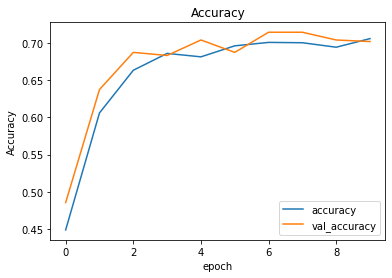

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc = 'lower right')
plt.show()

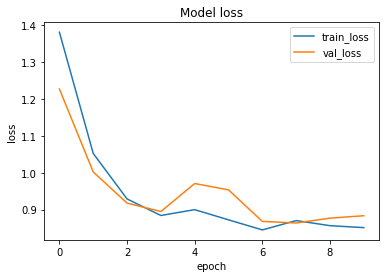

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [22]:
# Evaluate the performance of the model
from keras.models import load_model
saved_model = load_model("/content/drive/MyDrive/FY_BTech_Project/Saved Models/final_googlenet_multi.h5")
evaluate = saved_model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

30/30 [==============================] - 182s 6s/step - loss: 0.7707 - accuracy: 0.7375


In [23]:
print('Accuracy Test : {:.2f} %'.format(evaluate[1]*100))
print('Loss Test : {:.2f}'.format(evaluate[0]))

Accuracy Test : 73.75 %
Loss Test : 0.77


In [24]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [25]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = saved_model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 [==============================] - 0s 19ms/step


In [26]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {:.4f}%".format(score*100))

Test Accuracy : 73.7108%


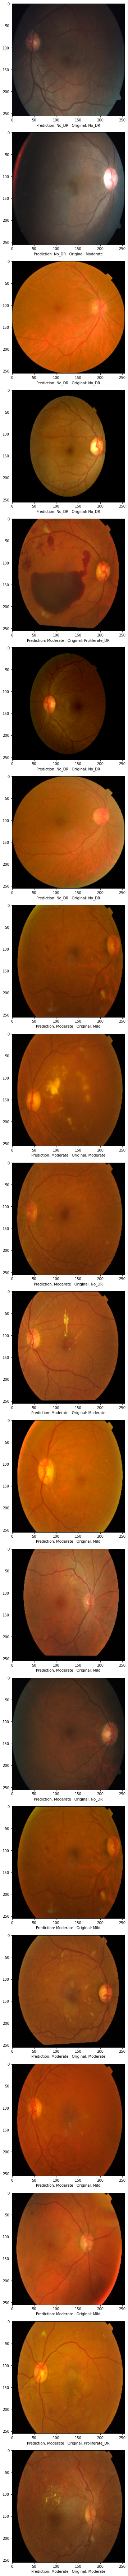

In [27]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import roc_curve,auc
print(classification_report(np.asarray(original), np.asarray(prediction)))

                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        82
      Moderate       0.53      0.95      0.68       281
         No_DR       0.96      0.92      0.94       500
Proliferate_DR       0.00      0.00      0.00        80
        Severe       0.00      0.00      0.00        46

      accuracy                           0.74       989
     macro avg       0.30      0.38      0.32       989
  weighted avg       0.63      0.74      0.67       989



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion_matrix')

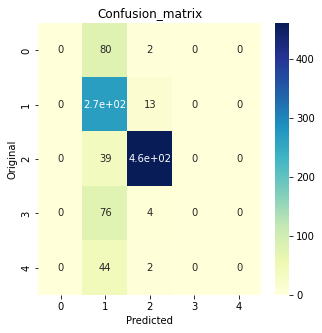

In [29]:
import seaborn as sns
plt.figure(figsize = (5,5))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu")

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [35]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
sensitivity = (TP/(TP + FN))
specificity = (TN/(TN + FP))
avgsens = (sensitivity[1]+sensitivity[2])/2
avgspec = (specificity[0]+specificity[1]+specificity[2]+specificity[3]+specificity[4])/5
print("Sensitivity : %.3f" % avgsens)
print("Specificity : %.3f" % avgspec)
print("\n\nSensitivity : "+str(sensitivity))
print("Specificity : "+str(specificity))

Sensitivity : 0.938
Specificity : 0.924


Sensitivity : [0.         0.95373665 0.922      0.         0.        ]
Specificity : [1.         0.66242938 0.95705521 1.         1.        ]


In [36]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
def multiclass_roc_auc_score(list1, list2, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(list1)
  list1 = lb.transform(list1)
  list2 = lb.transform(list2)
  return roc_auc_score(list1, list2, average=average)
print("AUC score: %.3f" % multiclass_roc_auc_score(original,prediction))

AUC score: 0.650


In [37]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(original,prediction)
print('Cohens Kappa: %.3f' % kappa)

Cohens Kappa: 0.568
